# 多量子比特系统可扩展性实验

## 实验概述

本实验专注于多量子比特系统的可扩展性分析，验证最大似然估计(MLE)方法在不同量子比特数下的性能表现。

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# 设置随机种子确保可重复性
np.random.seed(42)
torch.manual_seed(42)

# 设置matplotlib样式
plt.style.use('default')
sns.set_palette("husl")

print("环境配置完成！")

环境配置完成！


In [2]:
class MultiQubitQuantumTools:
    """多量子比特系统工具类（支持自定义维度）"""
    
    @staticmethod
    def random_pure_state(dim=None, n_qubits=None):
        """生成随机纯态
        Args:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        state = np.random.randn(dim) + 1j * np.random.randn(dim)
        return state / np.linalg.norm(state)
    
    @staticmethod
    def random_mixed_state(dim=None, n_qubits=None, purity=0.8):
        """生成随机混合态
        Args:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
            purity: 纯度
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        # 生成随机纯态
        psi = MultiQubitQuantumTools.random_pure_state(dim=dim)
        rho = np.outer(psi, psi.conj())
        
        # 添加噪声以创建混合态
        identity = np.eye(dim, dtype=complex)
        rho_mixed = purity * rho + (1 - purity) * identity / dim
        return rho_mixed / np.trace(rho_mixed)
    
    @staticmethod
    def GHZ_state(dim=None, n_qubits=None):
        """生成GHZ态
        Args:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        state = np.zeros(dim, dtype=complex)
        state[0] = 1/np.sqrt(2)
        state[-1] = 1/np.sqrt(2)
        return np.outer(state, state.conj())
    
    @staticmethod
    def W_state(dim=None, n_qubits=None):
        """生成W态
        Args:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        
        # 对于任意维度，生成W-like态：前n个基态的均匀叠加
        state = np.zeros(dim, dtype=complex)
        n_terms = min(dim, 3)  # 使用前3个或所有基态
        for i in range(n_terms):
            state[i] = 1/np.sqrt(n_terms)
        return np.outer(state, state.conj())
    
    @staticmethod
    def pauli_operators():
        """返回单量子比特Pauli算符"""
        I = np.array([[1, 0], [0, 1]], dtype=complex)
        X = np.array([[0, 1], [1, 0]], dtype=complex)
        Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
        Z = np.array([[1, 0], [0, -1]], dtype=complex)
        return [I, X, Y, Z]
    
    @staticmethod
    def multiqubit_pauli_matrices(n_qubits):
        """生成多量子比特Pauli测量算符"""
        paulis = MultiQubitQuantumTools.pauli_operators()
        
        if n_qubits == 1:
            return paulis
        
        # 多量子比特情况：张量积
        multi_paulis = []
        for ops in np.ndindex((4,) * n_qubits):
            op = paulis[ops[0]]
            for i in range(1, n_qubits):
                op = np.kron(op, paulis[ops[i]])
            multi_paulis.append(op)
        
        return multi_paulis
    
    @staticmethod
    def generate_measurement_basis(dim):
        """生成d维系统的测量基（使用Gell-Mann矩阵的推广）
        Args:
            dim: 量子态维度
        Returns:
            测量基列表（d^2个算符）
        """
        bases = []
        
        # 单位矩阵
        I = np.eye(dim, dtype=complex)
        bases.append(I)
        
        # 对称矩阵（Gell-Mann类型）
        for j in range(dim):
            for k in range(j+1, dim):
                # 对称矩阵 |j><k| + |k><j|
                M = np.zeros((dim, dim), dtype=complex)
                M[j, k] = 1
                M[k, j] = 1
                bases.append(M)
        
        # 反对称矩阵（Gell-Mann类型）
        for j in range(dim):
            for k in range(j+1, dim):
                # 反对称矩阵 -i|j><k| + i|k><j|
                M = np.zeros((dim, dim), dtype=complex)
                M[j, k] = -1j
                M[k, j] = 1j
                bases.append(M)
        
        # 对角矩阵（Gell-Mann类型）
        for l in range(1, dim):
            M = np.zeros((dim, dim), dtype=complex)
            # 前l个对角元素为1，第l个对角元素为-l
            for m in range(l):
                M[m, m] = 1
            M[l, l] = -l
            # 归一化
            M = M / np.sqrt(l * (l + 1))
            bases.append(M)
        
        # 如果数量不够d^2，补充随机正交基
        while len(bases) < dim * dim:
            # 生成随机厄米矩阵
            A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
            M = (A + A.conj().T) / 2
            # 归一化
            M = M / np.linalg.norm(M)
            bases.append(M)
        
        # 只取前d^2个
        return bases[:dim * dim]
    
    @staticmethod
    def simulate_measurements(rho, n_measurements=1000, noise_level=0.01, dim=None):
        """模拟具有shot noise和系统噪声的量子测量过程
        Args:
            rho: 密度矩阵
            n_measurements: 测量次数
            noise_level: 噪声水平
            dim: 量子态维度（如果提供，优先使用；否则从rho.shape[0]推断）
        """
        if dim is None:
            dim = rho.shape[0]
        
        # 判断是否是2的幂次（标准量子比特系统）
        n_qubits = None
        if dim & (dim - 1) == 0:  # 检查是否是2的幂次
            n_qubits = int(np.log2(dim))
            # 使用Pauli测量基
            paulis = MultiQubitQuantumTools.multiqubit_pauli_matrices(n_qubits)
            measurement_bases = paulis
        else:
            # 使用Gell-Mann类型的测量基
            measurement_bases = MultiQubitQuantumTools.generate_measurement_basis(dim)
        
        frequencies = []
        for basis in measurement_bases:
            # 计算期望值
            expectation = np.real(np.trace(rho @ basis))
            
            # 归一化到[0,1]范围（对于非Pauli基，需要调整）
            if n_qubits is not None:
                # Pauli基：期望值在[-1,1]，映射到[0,1]
                prob = np.clip((expectation + 1) / 2, 0, 1)
            else:
                # 其他基：期望值可能在更大范围，需要归一化
                # 使用sigmoid函数映射
                prob = np.clip(1 / (1 + np.exp(-expectation)), 0, 1)
            
            # Shot noise：对每个测量设置随机的shot数
            jitter = max(1, int(n_measurements * 0.2))
            shots = max(10, int(n_measurements + np.random.randint(-jitter, jitter + 1)))
            shot_freq = np.random.binomial(shots, prob) / shots
            
            # 系统噪声：附加高斯噪声
            noisy_freq = shot_freq + np.random.normal(0, noise_level)
            noisy_freq = np.clip(noisy_freq, 0, 1)
            frequencies.append(noisy_freq)
        
        return np.array(frequencies)
    
    @staticmethod
    def fidelity(rho1, rho2):
        """计算量子态保真度"""
        # 确保输入是numpy数组
        if hasattr(rho1, 'cpu'):
            rho1 = rho1.cpu().numpy()
        if hasattr(rho2, 'cpu'):
            rho2 = rho2.cpu().numpy()
        
        sqrt_rho1 = sqrtm(rho1)
        fidelity_matrix = sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1)
        return np.real(np.trace(fidelity_matrix))**2
    
    @staticmethod
    def constraint_violation(rho):
        """计算物理约束违反程度"""
        # 确保输入是numpy数组
        if hasattr(rho, 'cpu'):
            rho = rho.cpu().numpy()
        
        # 厄米性违反
        hermiticity = np.linalg.norm(rho - rho.conj().T)
        
        # 迹归一化违反
        trace_violation = abs(np.trace(rho) - 1)
        
        # 正定性违反 (最小特征值)
        eigenvals = np.linalg.eigvals(rho)
        positivity_violation = max(0, -np.real(eigenvals).min())
        
        return hermiticity + trace_violation + positivity_violation
    
    @staticmethod
    def cholesky_to_density_matrix(alpha, dim=None, n_qubits=None):
        """从Cholesky参数构造密度矩阵
        Args:
            alpha: Cholesky参数向量
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        n_params = dim * (dim + 1) // 2
        
        # 确保alpha是numpy数组
        if hasattr(alpha, 'cpu'):
            alpha = alpha.detach().cpu().numpy()
        alpha = np.array(alpha, dtype=np.float64).flatten()
        
        if alpha.size < 2 * n_params:
            alpha = np.pad(alpha, (0, 2 * n_params - alpha.size), mode='constant')
        
        # 根据参数还原下三角矩阵
        L = np.zeros((dim, dim), dtype=complex)
        idx = 0
        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    L[i, j] = abs(alpha[idx]) + 1e-9  # 对角元需为正
                    idx += 1
                else:
                    L[i, j] = alpha[idx] + 1j * alpha[idx + 1]
                    idx += 2
        
        rho = L @ L.conj().T
        rho = rho / np.trace(rho)
        return rho
    
    @staticmethod
    def density_to_cholesky_params(rho):
        """将密度矩阵转换为Cholesky参数向量"""
        if hasattr(rho, 'cpu'):
            rho = rho.detach().cpu().numpy()
        rho = np.array(rho, dtype=complex)
        rho = (rho + rho.conj().T) / 2  # 保证厄米
        dim = rho.shape[0]
        identity = np.eye(dim, dtype=complex)
        jitter = 1e-10
        for _ in range(6):
            try:
                L = np.linalg.cholesky(rho + jitter * identity)
                break
            except np.linalg.LinAlgError:
                jitter *= 10
        else:
            eigvals, eigvecs = np.linalg.eigh(rho)
            eigvals = np.clip(eigvals, 0, None)
            rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T + jitter * identity
            L = np.linalg.cholesky(rho)
        L = np.tril(L)
        params = []
        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    params.append(max(L[i, j].real, 1e-9))
                else:
                    params.append(L[i, j].real)
                    params.append(L[i, j].imag)
        return np.array(params, dtype=np.float32)
    
    @staticmethod
    def params_to_density_no_constraint(alpha, dim=None, n_qubits=None):
        """不施加Cholesky约束的直接参数->密度矩阵映射
        Args:
            alpha: 参数向量
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        # 这个方法在多量子比特情况下更加复杂，此处简化实现
        if hasattr(alpha, 'cpu'):
            alpha = alpha.detach().cpu().numpy()
        alpha = np.array(alpha, dtype=np.float64).flatten()
        
        rho = np.zeros((dim, dim), dtype=complex)
        idx = 0
        for i in range(dim):
            for j in range(dim):
                if idx < len(alpha) - 1:
                    rho[i, j] = alpha[idx] + 1j * alpha[idx + 1]
                    idx += 2
        
        trace = np.trace(rho)
        if abs(trace) < 1e-9:
            trace = 1e-9
        rho = rho / trace
        return rho

In [3]:
class MultiQubitDataset(Dataset):
    """多量子比特量子态层析数据集（支持自定义维度）"""
    
    STATE_TYPES = ['GHZ', 'W', 'RandomPure', 'RandomMixed']
    
    def __init__(self, dim=None, n_qubits=None, n_samples=1000, n_measurements=1000, noise_level=0.01):
        """
        Args:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
            n_samples: 样本数量
            n_measurements: 测量次数
            noise_level: 噪声水平
        """
        self.qt = MultiQubitQuantumTools()
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        self.dim = dim
        self.n_qubits = n_qubits
        
        # 生成描述字符串
        if n_qubits is not None and dim == 2**n_qubits:
            dim_str = f"{n_qubits}量子比特"
        else:
            dim_str = f"{dim}×{dim}"
        print(f"生成 {n_samples} 个 {dim_str} 量子态的数据集...")
        
        self.measurements = []
        self.true_states = []
        self.target_params = []
        self.state_types = []
        
        for i in tqdm(range(n_samples)):
            # 生成不同类型的量子态
            state_idx = i % 4
            state_type = self.STATE_TYPES[state_idx]
            if state_idx == 0:
                # GHZ态
                rho = self.qt.GHZ_state(dim=dim)
            elif state_idx == 1:
                # W态
                rho = self.qt.W_state(dim=dim)
            elif state_idx == 2:
                # 随机纯态
                psi = self.qt.random_pure_state(dim=dim)
                rho = np.outer(psi, psi.conj())
            else:
                # 随机混合态
                rho = self.qt.random_mixed_state(dim=dim)
            
            # 模拟测量
            freq = self.qt.simulate_measurements(rho, n_measurements, noise_level, dim=dim)
            
            self.measurements.append(freq)
            self.true_states.append(rho)
            self.state_types.append(state_type)
            
            # 真实Cholesky参数作为监督信号
            target_params = self.qt.density_to_cholesky_params(rho)
            self.target_params.append(target_params)
        
        self.measurements = np.array(self.measurements)
        self.true_states = np.array(self.true_states)
        self.target_params = np.array(self.target_params)
        self.state_types = np.array(self.state_types)
        
        print(f"数据集生成完成！")
        print(f"  测量数据形状: {self.measurements.shape}")
        print(f"  真实状态形状: {self.true_states.shape}")
        print(f"  目标参数形状: {self.target_params.shape}")
        print(f"  状态类型示例: {np.unique(self.state_types)}")
    
    def __len__(self):
        return len(self.measurements)
    
    def __getitem__(self, idx):
        return {
            'measurements': torch.FloatTensor(self.measurements[idx]),
            'true_state': self.true_states[idx],  # 保持为numpy数组
            'target_params': torch.FloatTensor(self.target_params[idx]),  # Cholesky参数
            'state_type': self.state_types[idx]
        }

In [4]:
class MaximumLikelihoodEstimation:
    """最大似然估计(MLE)量子态层析重建方法
    
    使用RρR算法进行迭代优化，确保重建的密度矩阵满足物理约束。
    支持自定义维度。
    """
    
    def __init__(self, dim=None, n_qubits=None, max_iterations=1000, tolerance=1e-8):
        """
        参数:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
            max_iterations: 最大迭代次数
            tolerance: 收敛容差
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        self.dim = dim
        self.n_qubits = n_qubits
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.qt = MultiQubitQuantumTools()
        
        # 生成测量算符
        if n_qubits is not None and dim == 2**n_qubits:
            # 使用Pauli测量算符
            self.measurement_operators = self.qt.multiqubit_pauli_matrices(n_qubits)
        else:
            # 使用Gell-Mann类型的测量基
            self.measurement_operators = self.qt.generate_measurement_basis(dim)
    
    def frequencies_to_expectations(self, frequencies):
        """将测量频率转换为期望值"""
        # 频率范围是[0, 1]，需要转换为期望值范围[-1, 1]
        expectations = 2 * frequencies - 1
        return expectations
    
    def linear_inversion(self, frequencies):
        """线性反演方法，作为MLE的初始值
        
        使用测量基展开：rho = (1/dim) * sum_i Tr(rho * M_i) * M_i
        其中 Tr(rho * M_i) = expectation_i = 2 * frequency_i - 1 (对于Pauli基)
        对于非Pauli基，需要调整归一化
        """
        dim = self.dim
        expectations = self.frequencies_to_expectations(frequencies)
        
        # 使用测量基展开重建密度矩阵
        # 对于Pauli基：Tr(P_i * P_j) = dim * delta_ij
        # 对于Gell-Mann基：需要不同的归一化
        rho = np.zeros((dim, dim), dtype=complex)
        
        # 判断是否是Pauli基
        is_pauli = (self.n_qubits is not None and self.dim == 2**self.n_qubits)
        
        for i, operator in enumerate(self.measurement_operators):
            if i < len(expectations):
                if is_pauli:
                    # Pauli基：标准展开
                    rho += expectations[i] * operator
                else:
                    # Gell-Mann基：需要调整归一化
                    # 对于Gell-Mann基，使用简单的线性组合
                    rho += expectations[i] * operator
        
        # 归一化
        if is_pauli:
            # Pauli基：除以dim
            rho = rho / dim
        else:
            # Gell-Mann基：需要不同的归一化
            # 简化处理：直接归一化到迹为1
            pass
        
        # 确保厄米性（理论上应该已经是厄米的，但数值误差可能导致不是）
        rho = (rho + rho.conj().T) / 2
        
        # 投影到正定锥：如果特征值为负，设为小的正数
        eigvals, eigvecs = np.linalg.eigh(rho)
        eigvals = np.clip(eigvals, 1e-12, None)  # 确保所有特征值都是正数
        rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
        
        # 归一化到迹为1
        trace = np.trace(rho)
        if abs(trace) > 1e-10:
            rho = rho / trace
        else:
            # 如果迹太小，使用最大混合态作为fallback
            rho = np.eye(dim, dtype=complex) / dim
        
        return rho
    
    def rho_r_algorithm(self, frequencies, n_shots=None):
        """RρR算法进行最大似然估计
        
        参数:
            frequencies: 测量频率数组
            n_shots: 每个测量的shot数（用于加权）
        
        返回:
            重建的密度矩阵
        """
        dim = self.dim
        
        # 处理n_shots参数：如果是整数，转换为数组；如果是None，使用默认值
        if n_shots is None:
            n_shots = np.ones(len(frequencies)) * 1000
        elif isinstance(n_shots, (int, float)):
            # 如果是单个数值，转换为数组
            n_shots = np.ones(len(frequencies)) * n_shots
        else:
            # 确保是numpy数组
            n_shots = np.array(n_shots)
        
        # 使用线性反演作为初始值
        rho = self.linear_inversion(frequencies)
        
        # RρR迭代
        for iteration in range(self.max_iterations):
            rho_old = rho.copy()
            
            # 计算R矩阵
            # 标准RρR算法：R = (1/dim) * sum_i (f_obs_i / p_current_i) * M_i
            # 其中 f_obs_i 是观察到的频率，p_current_i 是当前密度矩阵下测量i的概率
            # 对于Pauli测量：p_i = (Tr(ρ * P_i) + 1) / 2
            # 对于非Pauli测量：需要调整概率计算
            R = np.zeros((dim, dim), dtype=complex)
            
            # 判断是否是Pauli基
            is_pauli = (self.n_qubits is not None and self.dim == 2**self.n_qubits)
            
            for i, operator in enumerate(self.measurement_operators):
                if i >= len(frequencies):
                    continue
                
                # 计算当前rho下的期望值
                exp_current = np.real(np.trace(rho @ operator))
                
                # 计算测量概率
                if is_pauli:
                    # 对于Pauli算符，p = (E + 1) / 2
                    prob_current = (exp_current + 1) / 2
                else:
                    # 对于非Pauli基，使用sigmoid函数
                    prob_current = 1 / (1 + np.exp(-exp_current))
                
                prob_observed = frequencies[i]
                
                # 避免除零和边界情况
                prob_current = np.clip(prob_current, 1e-10, 1 - 1e-10)
                prob_observed = np.clip(prob_observed, 0, 1)
                
                # R矩阵更新项：标准RρR算法
                # ratio = f_obs / p_current
                ratio = prob_observed / prob_current
                R += ratio * operator
            
            # 归一化R矩阵：除以维度
            # 标准RρR算法：R = (1/dim) * sum_i (f_i / p_i) * M_i
            R = R / dim
            
            # 更新rho: rho_new = R * rho * R / Tr(R * rho * R)
            rho_R = R @ rho @ R
            trace_R = np.trace(rho_R)
            
            if abs(trace_R) > 1e-10:
                rho = rho_R / trace_R
            else:
                # 如果迹太小，停止迭代
                break
            
            # 检查收敛
            diff = np.linalg.norm(rho - rho_old)
            if diff < self.tolerance:
                break
        
        # 最终确保物理约束
        rho = (rho + rho.conj().T) / 2  # 厄米性
        eigvals, eigvecs = np.linalg.eigh(rho)
        eigvals = np.clip(eigvals, 0, None)  # 正定性
        rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
        trace = np.trace(rho)
        if abs(trace) > 1e-10:
            rho = rho / trace  # 归一化
        
        return rho
    
    def reconstruct(self, frequencies, n_shots=None):
        """重建量子态
        
        参数:
            frequencies: 测量频率数组
            n_shots: 每个测量的shot数
        
        返回:
            重建的密度矩阵
        """
        return self.rho_r_algorithm(frequencies, n_shots)

In [5]:
# ============================================================================
# 基线模型：最小二乘法
# ============================================================================

class LeastSquares:
    """最小二乘法 - 基线模型2
    
    最小化测量数据与预测值的平方误差。
    使用加权最小二乘法，考虑不同测量的不确定性。
    支持自定义维度。
    """
    
    def __init__(self, dim=None, n_qubits=None):
        """
        参数:
            dim: 量子态维度（如果提供，优先使用）
            n_qubits: 量子比特数（如果dim未提供，则使用2**n_qubits）
        """
        if dim is None:
            dim = 2**n_qubits if n_qubits is not None else 4
        self.dim = dim
        self.n_qubits = n_qubits
        self.qt = MultiQubitQuantumTools()
        
        # 生成测量算符
        if n_qubits is not None and dim == 2**n_qubits:
            # 使用Pauli测量算符
            self.measurement_operators = self.qt.multiqubit_pauli_matrices(n_qubits)
        else:
            # 使用Gell-Mann类型的测量基
            self.measurement_operators = self.qt.generate_measurement_basis(dim)
    
    def frequencies_to_expectations(self, frequencies):
        """将测量频率转换为期望值"""
        return 2 * frequencies - 1
    
    def reconstruct(self, frequencies, weights=None):
        """使用最小二乘法重建量子态
        
        参数:
            frequencies: 测量频率数组
            weights: 权重数组（可选，用于加权最小二乘）
        
        返回:
            重建的密度矩阵
        """
        dim = self.dim
        expectations = self.frequencies_to_expectations(frequencies)
        
        # 如果没有提供权重，使用均匀权重
        if weights is None:
            weights = np.ones(len(frequencies))
        
        # 判断是否是Pauli基
        is_pauli = (self.n_qubits is not None and self.dim == 2**self.n_qubits)
        
        # 使用测量基展开重建密度矩阵
        rho = np.zeros((dim, dim), dtype=complex)
        
        for i, operator in enumerate(self.measurement_operators):
            if i >= len(expectations):
                break
            # 对于最小二乘，直接使用期望值
            rho += expectations[i] * operator
        
        # 归一化
        if is_pauli:
            # 标准Pauli基展开公式：rho = (1/dim) * sum_i expectation_i * P_i
            rho = rho / dim
        else:
            # 对于非Pauli基，直接归一化到迹为1
            pass
        
        # 确保厄米性
        rho = (rho + rho.conj().T) / 2
        
        # 投影到正定锥（如果特征值为负，设为0）
        eigvals, eigvecs = np.linalg.eigh(rho)
        eigvals = np.clip(eigvals, 0, None)
        rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T
        
        # 归一化
        trace = np.trace(rho)
        if abs(trace) > 1e-10:
            rho = rho / trace
        else:
            rho = np.eye(dim, dtype=complex) / dim
        
        return rho

In [6]:
# 通用评估函数（支持所有基线模型）
def evaluate_model(model, test_loader, model_name="Model", **kwargs):
    """评估量子态层析模型的性能
    
    参数:
        model: 模型实例（LeastSquares 或 MaximumLikelihoodEstimation）
        test_loader: 测试数据加载器
        model_name: 模型名称（用于显示）
        **kwargs: 模型特定的参数（如n_shots）
    
    返回:
        包含评估指标的字典
    """
    qt = MultiQubitQuantumTools()
    
    fidelities = []
    constraint_violations = []
    
    # 获取维度信息用于显示
    if hasattr(model, 'n_qubits') and model.n_qubits is not None:
        dim_str = f"{model.n_qubits}量子比特"
    elif hasattr(model, 'dim'):
        dim_str = f"{model.dim}×{model.dim}"
    else:
        dim_str = "未知维度"
    print(f"开始评估{model_name}模型（{dim_str}）...")
    
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        measurements = batch['measurements'].numpy()
        true_states = batch['true_state']
        
        # 对每个样本进行重建
        for i in range(len(measurements)):
            freq = measurements[i]
            
            # 根据模型类型调用不同的重建方法
            if isinstance(model, MaximumLikelihoodEstimation):
                rho_pred = model.reconstruct(freq, n_shots=kwargs.get('n_shots', None))
            elif isinstance(model, LeastSquares):
                rho_pred = model.reconstruct(freq, weights=kwargs.get('weights', None))
            else:
                raise ValueError(f"未知的模型类型: {type(model)}")
            
            # 获取真实状态
            rho_true = true_states[i]
            if hasattr(rho_true, 'cpu'):
                rho_true = rho_true.cpu().numpy()
            
            # 计算保真度
            fid = qt.fidelity(rho_pred, rho_true)
            fidelities.append(fid)
            
            # 计算约束违反
            cv = qt.constraint_violation(rho_pred)
            constraint_violations.append(cv)
    
    results = {
        'fidelity_mean': np.mean(fidelities) if fidelities else None,
        'fidelity_std': np.std(fidelities) if fidelities else None,
        'cv_mean': np.mean(constraint_violations) if constraint_violations else None,
        'cv_std': np.std(constraint_violations) if constraint_violations else None,
    }
    
    return results



In [7]:
# 评估函数已移至Cell 6，此Cell保留为空

## 实验执行 - 2量子比特系统

In [8]:
# 检查CUDA可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 生成2量子比特数据集
n_qubits = 2
train_dataset = MultiQubitDataset(n_qubits=n_qubits, n_samples=8000, n_measurements=256, noise_level=0.02)
test_dataset = MultiQubitDataset(n_qubits=n_qubits, n_samples=2000, n_measurements=256, noise_level=0.02)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"测量数据维度: {train_dataset.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset.target_params.shape[1]}")

# 数据验证
print("数据样本验证:")
sample_batch = next(iter(train_loader))
print(f"批次测量数据形状: {sample_batch['measurements'].shape}")
print(f"批次目标参数形状: {sample_batch['target_params'].shape}")
print(f"批次真实状态形状: {sample_batch['true_state'].shape}")

使用设备: cpu
生成 8000 个 2量子比特 量子态的数据集...


100%|██████████| 8000/8000 [00:03<00:00, 2072.43it/s]


数据集生成完成！
  测量数据形状: (8000, 16)
  真实状态形状: (8000, 4, 4)
  目标参数形状: (8000, 16)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 2000 个 2量子比特 量子态的数据集...


100%|██████████| 2000/2000 [00:00<00:00, 2043.58it/s]

数据集生成完成！
  测量数据形状: (2000, 16)
  真实状态形状: (2000, 4, 4)
  目标参数形状: (2000, 16)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
训练集大小: 8000
测试集大小: 2000
测量数据维度: 16
目标参数维度: 16
数据样本验证:
批次测量数据形状: torch.Size([32, 16])
批次目标参数形状: torch.Size([32, 16])
批次真实状态形状: torch.Size([32, 4, 4])


## 模型训练与比较

In [9]:
# 创建所有基线模型
print("=" * 60)
print("创建基线模型")
print("=" * 60)

# 1. 最小二乘法模型
ls_model_2 = LeastSquares(n_qubits=n_qubits)
print(f"\n✓ 最小二乘法模型创建完成（{n_qubits}量子比特）")

# 2. MLE模型（增加迭代次数以提高精度）
mle_model_2 = MaximumLikelihoodEstimation(n_qubits=n_qubits, max_iterations=1000, tolerance=1e-8)
print(f"✓ MLE模型创建完成（{n_qubits}量子比特）")
print(f"  最大迭代次数: {mle_model_2.max_iterations}")
print(f"  收敛容差: {mle_model_2.tolerance}")

print("\n所有模型创建完成！")

创建基线模型

✓ 最小二乘法模型创建完成（2量子比特）
✓ MLE模型创建完成（2量子比特）
  最大迭代次数: 1000
  收敛容差: 1e-08

所有模型创建完成！


In [10]:
# 评估所有基线模型
print(f"\n{'='*60}")
print(f"评估 2量子比特系统 - 所有基线模型")
print(f"{'='*60}")

results = {}

# 1. 评估最小二乘法模型
print(f"\n{'-'*60}")
eval_results_ls = evaluate_model(ls_model_2, test_loader, model_name="最小二乘法")
results['Least Squares'] = eval_results_ls
print(f"\n最小二乘法 最终评估结果:")
for key, value in eval_results_ls.items():
    if value is not None:
        print(f"  {key}: {value:.6f}")

# 2. 评估MLE模型
print(f"\n{'-'*60}")
eval_results_mle = evaluate_model(mle_model_2, test_loader, model_name="MLE", n_shots=256)
results['MLE'] = eval_results_mle
print(f"\nMLE 最终评估结果:")
for key, value in eval_results_mle.items():
    if value is not None:
        print(f"  {key}: {value:.6f}")

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n2量子比特系统评估完成！")


评估 2量子比特系统 - 所有基线模型

------------------------------------------------------------
开始评估最小二乘法模型（2量子比特）...


100%|██████████| 63/63 [00:00<00:00, 133.21it/s]



最小二乘法 最终评估结果:
  fidelity_mean: 0.934619
  fidelity_std: 0.020151
  cv_mean: 0.000000
  cv_std: 0.000000

------------------------------------------------------------
开始评估MLE模型（2量子比特）...


100%|██████████| 63/63 [00:22<00:00,  2.80it/s]


MLE 最终评估结果:
  fidelity_mean: 0.528110
  fidelity_std: 0.246036
  cv_mean: 0.000000
  cv_std: 0.000000

模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.934619        0.020151        1.323424e-16   
MLE                  0.528110        0.246036        8.996623e-17   

2量子比特系统评估完成！


## 3×3维量子态系统扩展实验

In [11]:
# 生成3×3维量子态数据集（替代原来的3量子比特）
dim_3 = 3
train_dataset_3 = MultiQubitDataset(dim=dim_3, n_samples=6000, n_measurements=128, noise_level=0.03)
test_dataset_3 = MultiQubitDataset(dim=dim_3, n_samples=1500, n_measurements=128, noise_level=0.03)

# 创建数据加载器
train_loader_3 = DataLoader(train_dataset_3, batch_size=32, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=32, shuffle=False)

print(f"3×3维量子态系统:")
print(f"训练集大小: {len(train_dataset_3)}")
print(f"测试集大小: {len(test_dataset_3)}")
print(f"测量数据维度: {train_dataset_3.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_3.target_params.shape[1]}")

生成 6000 个 3×3 量子态的数据集...


100%|██████████| 6000/6000 [00:01<00:00, 5087.81it/s]


数据集生成完成！
  测量数据形状: (6000, 9)
  真实状态形状: (6000, 3, 3)
  目标参数形状: (6000, 9)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 1500 个 3×3 量子态的数据集...


100%|██████████| 1500/1500 [00:00<00:00, 5589.30it/s]

数据集生成完成！
  测量数据形状: (1500, 9)
  真实状态形状: (1500, 3, 3)
  目标参数形状: (1500, 9)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
3×3维量子态系统:
训练集大小: 6000
测试集大小: 1500
测量数据维度: 9
目标参数维度: 9


In [12]:
# 创建并评估3×3维量子态所有基线模型
print(f"\n{'='*60}")
print("创建3×3维量子态基线模型")
print(f"{'='*60}")

ls_model_3 = LeastSquares(dim=dim_3)
mle_model_3 = MaximumLikelihoodEstimation(dim=dim_3, max_iterations=1000, tolerance=1e-8)

print(f"\n{'='*60}")
print(f"评估 3×3维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_3 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_3, test_loader_3, model_name="最小二乘法")
results_3['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_3, test_loader_3, model_name="MLE", n_shots=128)
results_3['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_3.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n3×3维量子态系统评估完成！")


创建3×3维量子态基线模型

评估 3×3维量子态系统 - 所有基线模型
开始评估最小二乘法模型（3×3）...


100%|██████████| 47/47 [00:00<00:00, 259.15it/s]


开始评估MLE模型（3×3）...


100%|██████████| 47/47 [00:05<00:00,  7.90it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.762597        0.099819        1.066050e-16   
MLE                  0.560527        0.252110        9.967325e-17   

3×3维量子态系统评估完成！


## 4×4维量子态系统扩展实验


In [13]:
# 生成4×4维量子态数据集（替代原来的4量子比特）
dim_4 = 4
train_dataset_4 = MultiQubitDataset(
    dim=dim_4,
    n_samples=8000,
    n_measurements=512,
    noise_level=0.03
)
test_dataset_4 = MultiQubitDataset(
    dim=dim_4,
    n_samples=1500,
    n_measurements=512,
    noise_level=0.03
)

train_loader_4 = DataLoader(train_dataset_4, batch_size=32, shuffle=True)
test_loader_4 = DataLoader(test_dataset_4, batch_size=32, shuffle=False)

print("4×4维量子态数据配置：")
print(f"训练集大小: {len(train_dataset_4)}")
print(f"测试集大小: {len(test_dataset_4)}")
print(f"测量数据维度: {train_dataset_4.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_4.target_params.shape[1]}")


生成 8000 个 4×4 量子态的数据集...


100%|██████████| 8000/8000 [00:03<00:00, 2000.43it/s]


数据集生成完成！
  测量数据形状: (8000, 16)
  真实状态形状: (8000, 4, 4)
  目标参数形状: (8000, 16)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 1500 个 4×4 量子态的数据集...


100%|██████████| 1500/1500 [00:00<00:00, 2035.73it/s]

数据集生成完成！
  测量数据形状: (1500, 16)
  真实状态形状: (1500, 4, 4)
  目标参数形状: (1500, 16)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
4×4维量子态数据配置：
训练集大小: 8000
测试集大小: 1500
测量数据维度: 16
目标参数维度: 16


In [14]:
# 创建并评估4×4维量子态所有基线模型
print(f"\n{'='*60}")
print("创建4×4维量子态基线模型")
print(f"{'='*60}")

ls_model_4 = LeastSquares(dim=dim_4)
mle_model_4 = MaximumLikelihoodEstimation(dim=dim_4, max_iterations=300, tolerance=1e-6)

print(f"\n{'='*60}")
print(f"评估 4×4维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_4 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_4, test_loader_4, model_name="最小二乘法")
results_4['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_4, test_loader_4, model_name="MLE", n_shots=512)
results_4['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_4.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n4×4维量子态系统评估完成！")


创建4×4维量子态基线模型

评估 4×4维量子态系统 - 所有基线模型
开始评估最小二乘法模型（4×4）...


100%|██████████| 47/47 [00:00<00:00, 214.76it/s]


开始评估MLE模型（4×4）...


100%|██████████| 47/47 [00:06<00:00,  6.92it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.343257        0.147552        1.176288e-16   
MLE                  0.404127        0.225197        1.163474e-16   

4×4维量子态系统评估完成！


## 5×5维量子态系统扩展实验


In [15]:
# 生成5×5维量子态数据集（替代原来的5量子比特）
dim_5 = 5
train_dataset_5 = MultiQubitDataset(dim=dim_5, n_samples=3000, n_measurements=32, noise_level=0.05)
test_dataset_5 = MultiQubitDataset(dim=dim_5, n_samples=800, n_measurements=32, noise_level=0.05)

# 创建数据加载器（进一步减小batch size以适应更大的参数空间）
train_loader_5 = DataLoader(train_dataset_5, batch_size=8, shuffle=True)
test_loader_5 = DataLoader(test_dataset_5, batch_size=8, shuffle=False)

print(f"5×5维量子态系统:")
print(f"训练集大小: {len(train_dataset_5)}")
print(f"测试集大小: {len(test_dataset_5)}")
print(f"测量数据维度: {train_dataset_5.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_5.target_params.shape[1]}")


生成 3000 个 5×5 量子态的数据集...


100%|██████████| 3000/3000 [00:01<00:00, 2142.62it/s]


数据集生成完成！
  测量数据形状: (3000, 25)
  真实状态形状: (3000, 5, 5)
  目标参数形状: (3000, 25)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 800 个 5×5 量子态的数据集...


100%|██████████| 800/800 [00:00<00:00, 2167.17it/s]

数据集生成完成！
  测量数据形状: (800, 25)
  真实状态形状: (800, 5, 5)
  目标参数形状: (800, 25)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
5×5维量子态系统:
训练集大小: 3000
测试集大小: 800
测量数据维度: 25
目标参数维度: 25


In [16]:
# 创建并评估5×5维量子态所有基线模型
print(f"\n{'='*60}")
print("创建5×5维量子态基线模型")
print(f"{'='*60}")

ls_model_5 = LeastSquares(dim=dim_5)
mle_model_5 = MaximumLikelihoodEstimation(dim=dim_5, max_iterations=200, tolerance=1e-6)

print(f"\n{'='*60}")
print(f"评估 5×5维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_5 = {}


# 2. 最小二乘法
eval_results_ls = evaluate_model(ls_model_5, test_loader_5, model_name="最小二乘法")
results_5['Least Squares'] = eval_results_ls


eval_results_mle = evaluate_model(mle_model_5, test_loader_5, model_name="MLE", n_shots=32)
results_5['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_5.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n5×5维量子态系统评估完成！")



创建5×5维量子态基线模型

评估 5×5维量子态系统 - 所有基线模型
开始评估最小二乘法模型（5×5）...


100%|██████████| 100/100 [00:00<00:00, 775.76it/s]


开始评估MLE模型（5×5）...


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.468363        0.120187        1.337887e-16   
MLE                  0.379343        0.214194        1.427492e-16   

5×5维量子态系统评估完成！


## 基线模型精度分析

### 为什么线性反演和最小二乘法精度可能很高？

**主要原因：**

1. **直接使用测量数据，无迭代误差**
   - 线性反演和最小二乘法直接从测量频率计算，没有迭代优化过程
   - 如果测量数据质量好（噪声水平低），它们可能直接给出接近真实值的结果
   - MLE需要迭代优化，可能引入迭代误差或收敛到局部最优

2. **测量数据质量**
   - 实验中的噪声水平较低（0.02-0.05）
   - 测量次数足够（256-512次）
   - 线性反演直接使用这些高质量数据，可能已经足够准确

3. **MLE的RρR算法特性**
   - RρR算法从线性反演的结果开始迭代
   - 如果初始值（线性反演）已经很好，MLE的改进空间有限
   - RρR算法可能收敛到局部最优，而不是全局最优

4. **物理约束的权衡**
   - 线性反演不施加正定性约束，可能产生负特征值（非物理）
   - 但保真度计算对非物理态仍然可以给出数值结果
   - MLE保证物理性，但可能因为约束而略微偏离最优解

**注意事项：**
- 线性反演虽然保真度可能很高，但可能产生非物理结果（有负特征值）
- 最小二乘法投影到正定锥，平衡了速度和物理性
- MLE理论上是最优的，但需要充分迭代才能收敛


## 应用示例：量子纠缠健康监测

依托PINN重建得到的密度矩阵，我们可以即时评估量子设备在生产GHZ/W等目标纠缠态时是否“偏离健康状态”。
核心步骤：
- 使用训练好的PINN模型在线重建密度矩阵；
- 计算与目标标准态的保真度，并根据阈值触发告警；
- 输出纠缠态类别判别和综合健康评分，可直接反馈给实验控制系统，实现“表征→诊断→调参”的闭环。


## 6×6维量子态系统扩展实验


In [17]:
# 生成6×6维量子态数据集
dim_6 = 6
train_dataset_6 = MultiQubitDataset(dim=dim_6, n_samples=2000, n_measurements=64, noise_level=0.05)
test_dataset_6 = MultiQubitDataset(dim=dim_6, n_samples=500, n_measurements=64, noise_level=0.05)

# 创建数据加载器（减小batch size以适应更大的参数空间）
train_loader_6 = DataLoader(train_dataset_6, batch_size=8, shuffle=True)
test_loader_6 = DataLoader(test_dataset_6, batch_size=8, shuffle=False)

print(f"6×6维量子态系统:")
print(f"训练集大小: {len(train_dataset_6)}")
print(f"测试集大小: {len(test_dataset_6)}")
print(f"测量数据维度: {train_dataset_6.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_6.target_params.shape[1]}")


生成 2000 个 6×6 量子态的数据集...


100%|██████████| 2000/2000 [00:01<00:00, 1367.88it/s]


数据集生成完成！
  测量数据形状: (2000, 36)
  真实状态形状: (2000, 6, 6)
  目标参数形状: (2000, 36)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 500 个 6×6 量子态的数据集...


100%|██████████| 500/500 [00:00<00:00, 1551.97it/s]

数据集生成完成！
  测量数据形状: (500, 36)
  真实状态形状: (500, 6, 6)
  目标参数形状: (500, 36)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
6×6维量子态系统:
训练集大小: 2000
测试集大小: 500
测量数据维度: 36
目标参数维度: 36


In [18]:
# 创建并评估6×6维量子态所有基线模型
print(f"\n{'='*60}")
print("创建6×6维量子态基线模型")
print(f"{'='*60}")

ls_model_6 = LeastSquares(dim=dim_6)
mle_model_6 = MaximumLikelihoodEstimation(dim=dim_6, max_iterations=150, tolerance=1e-5)

print(f"\n{'='*60}")
print(f"评估 6×6维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_6 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_6, test_loader_6, model_name="最小二乘法")
results_6['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_6, test_loader_6, model_name="MLE", n_shots=64)
results_6['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_6.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n6×6维量子态系统评估完成！")



创建6×6维量子态基线模型

评估 6×6维量子态系统 - 所有基线模型
开始评估最小二乘法模型（6×6）...


100%|██████████| 63/63 [00:00<00:00, 695.52it/s]


开始评估MLE模型（6×6）...


100%|██████████| 63/63 [00:04<00:00, 14.24it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.426027        0.120271        1.359412e-16   
MLE                  0.328364        0.191922        1.804802e-16   

6×6维量子态系统评估完成！


## 7×7维量子态系统扩展实验


In [19]:
# 生成7×7维量子态数据集
dim_7 = 7
train_dataset_7 = MultiQubitDataset(dim=dim_7, n_samples=1500, n_measurements=64, noise_level=0.05)
test_dataset_7 = MultiQubitDataset(dim=dim_7, n_samples=400, n_measurements=64, noise_level=0.05)

# 创建数据加载器（进一步减小batch size）
train_loader_7 = DataLoader(train_dataset_7, batch_size=4, shuffle=True)
test_loader_7 = DataLoader(test_dataset_7, batch_size=4, shuffle=False)

print(f"7×7维量子态系统:")
print(f"训练集大小: {len(train_dataset_7)}")
print(f"测试集大小: {len(test_dataset_7)}")
print(f"测量数据维度: {train_dataset_7.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_7.target_params.shape[1]}")


生成 1500 个 7×7 量子态的数据集...


100%|██████████| 1500/1500 [00:01<00:00, 1154.62it/s]


数据集生成完成！
  测量数据形状: (1500, 49)
  真实状态形状: (1500, 7, 7)
  目标参数形状: (1500, 49)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 400 个 7×7 量子态的数据集...


100%|██████████| 400/400 [00:00<00:00, 1115.96it/s]

数据集生成完成！
  测量数据形状: (400, 49)
  真实状态形状: (400, 7, 7)
  目标参数形状: (400, 49)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
7×7维量子态系统:
训练集大小: 1500
测试集大小: 400
测量数据维度: 49
目标参数维度: 49


In [20]:
# 创建并评估7×7维量子态所有基线模型
print(f"\n{'='*60}")
print("创建7×7维量子态基线模型")
print(f"{'='*60}")

ls_model_7 = LeastSquares(dim=dim_7)
mle_model_7 = MaximumLikelihoodEstimation(dim=dim_7, max_iterations=100, tolerance=1e-5)

print(f"\n{'='*60}")
print(f"评估 7×7维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_7 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_7, test_loader_7, model_name="最小二乘法")
results_7['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_7, test_loader_7, model_name="MLE", n_shots=64)
results_7['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_7.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n7×7维量子态系统评估完成！")



创建7×7维量子态基线模型

评估 7×7维量子态系统 - 所有基线模型
开始评估最小二乘法模型（7×7）...


100%|██████████| 100/100 [00:00<00:00, 378.45it/s]


开始评估MLE模型（7×7）...


100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.371887        0.122452        1.410515e-16   
MLE                  0.270569        0.174226        1.963708e-16   

7×7维量子态系统评估完成！


## 8×8维量子态系统扩展实验


In [21]:
# 生成8×8维量子态数据集
dim_8 = 8
train_dataset_8 = MultiQubitDataset(dim=dim_8, n_samples=1200, n_measurements=64, noise_level=0.05)
test_dataset_8 = MultiQubitDataset(dim=dim_8, n_samples=300, n_measurements=64, noise_level=0.05)

# 创建数据加载器（进一步减小batch size）
train_loader_8 = DataLoader(train_dataset_8, batch_size=4, shuffle=True)
test_loader_8 = DataLoader(test_dataset_8, batch_size=4, shuffle=False)

print(f"8×8维量子态系统:")
print(f"训练集大小: {len(train_dataset_8)}")
print(f"测试集大小: {len(test_dataset_8)}")
print(f"测量数据维度: {train_dataset_8.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_8.target_params.shape[1]}")


生成 1200 个 8×8 量子态的数据集...


100%|██████████| 1200/1200 [00:02<00:00, 436.30it/s]


数据集生成完成！
  测量数据形状: (1200, 64)
  真实状态形状: (1200, 8, 8)
  目标参数形状: (1200, 64)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 300 个 8×8 量子态的数据集...


100%|██████████| 300/300 [00:00<00:00, 456.99it/s]

数据集生成完成！
  测量数据形状: (300, 64)
  真实状态形状: (300, 8, 8)
  目标参数形状: (300, 64)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
8×8维量子态系统:
训练集大小: 1200
测试集大小: 300
测量数据维度: 64
目标参数维度: 64


In [22]:
# 创建并评估8×8维量子态所有基线模型
print(f"\n{'='*60}")
print("创建8×8维量子态基线模型")
print(f"{'='*60}")

ls_model_8 = LeastSquares(dim=dim_8)
mle_model_8 = MaximumLikelihoodEstimation(dim=dim_8, max_iterations=100, tolerance=1e-5)

print(f"\n{'='*60}")
print(f"评估 8×8维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_8 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_8, test_loader_8, model_name="最小二乘法")
results_8['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_8, test_loader_8, model_name="MLE", n_shots=64)
results_8['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_8.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n8×8维量子态系统评估完成！")



创建8×8维量子态基线模型

评估 8×8维量子态系统 - 所有基线模型
开始评估最小二乘法模型（8×8）...


100%|██████████| 75/75 [00:00<00:00, 905.48it/s]


开始评估MLE模型（8×8）...


100%|██████████| 75/75 [00:04<00:00, 16.57it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.214105        0.121089        1.188224e-16   
MLE                  0.221933        0.147485        1.679365e-16   

8×8维量子态系统评估完成！


## 9×9维量子态系统扩展实验


In [23]:
# 生成9×9维量子态数据集
dim_9 = 9
train_dataset_9 = MultiQubitDataset(dim=dim_9, n_samples=1000, n_measurements=64, noise_level=0.05)
test_dataset_9 = MultiQubitDataset(dim=dim_9, n_samples=250, n_measurements=64, noise_level=0.05)

# 创建数据加载器（进一步减小batch size）
train_loader_9 = DataLoader(train_dataset_9, batch_size=4, shuffle=True)
test_loader_9 = DataLoader(test_dataset_9, batch_size=4, shuffle=False)

print(f"9×9维量子态系统:")
print(f"训练集大小: {len(train_dataset_9)}")
print(f"测试集大小: {len(test_dataset_9)}")
print(f"测量数据维度: {train_dataset_9.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_9.target_params.shape[1]}")


生成 1000 个 9×9 量子态的数据集...


100%|██████████| 1000/1000 [00:01<00:00, 654.44it/s]


数据集生成完成！
  测量数据形状: (1000, 81)
  真实状态形状: (1000, 9, 9)
  目标参数形状: (1000, 81)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 250 个 9×9 量子态的数据集...


100%|██████████| 250/250 [00:00<00:00, 708.99it/s]

数据集生成完成！
  测量数据形状: (250, 81)
  真实状态形状: (250, 9, 9)
  目标参数形状: (250, 81)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
9×9维量子态系统:
训练集大小: 1000
测试集大小: 250
测量数据维度: 81
目标参数维度: 81


In [24]:
# 创建并评估9×9维量子态所有基线模型
print(f"\n{'='*60}")
print("创建9×9维量子态基线模型")
print(f"{'='*60}")

ls_model_9 = LeastSquares(dim=dim_9)
mle_model_9 = MaximumLikelihoodEstimation(dim=dim_9, max_iterations=80, tolerance=1e-5)

print(f"\n{'='*60}")
print(f"评估 9×9维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_9 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_9, test_loader_9, model_name="最小二乘法")
results_9['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_9, test_loader_9, model_name="MLE", n_shots=64)
results_9['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_9.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n9×9维量子态系统评估完成！")



创建9×9维量子态基线模型

评估 9×9维量子态系统 - 所有基线模型
开始评估最小二乘法模型（9×9）...


100%|██████████| 63/63 [00:00<00:00, 938.38it/s]


开始评估MLE模型（9×9）...


100%|██████████| 63/63 [00:04<00:00, 14.42it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.300964        0.121338        1.309435e-16   
MLE                  0.214676        0.137534        1.801865e-16   

9×9维量子态系统评估完成！


## 10×10维量子态系统扩展实验


In [25]:
# 生成10×10维量子态数据集
dim_10 = 10
train_dataset_10 = MultiQubitDataset(dim=dim_10, n_samples=800, n_measurements=64, noise_level=0.05)
test_dataset_10 = MultiQubitDataset(dim=dim_10, n_samples=200, n_measurements=64, noise_level=0.05)

# 创建数据加载器（使用最小batch size）
train_loader_10 = DataLoader(train_dataset_10, batch_size=2, shuffle=True)
test_loader_10 = DataLoader(test_dataset_10, batch_size=2, shuffle=False)

print(f"10×10维量子态系统:")
print(f"训练集大小: {len(train_dataset_10)}")
print(f"测试集大小: {len(test_dataset_10)}")
print(f"测量数据维度: {train_dataset_10.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_10.target_params.shape[1]}")


生成 800 个 10×10 量子态的数据集...


100%|██████████| 800/800 [00:01<00:00, 568.06it/s]


数据集生成完成！
  测量数据形状: (800, 100)
  真实状态形状: (800, 10, 10)
  目标参数形状: (800, 100)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
生成 200 个 10×10 量子态的数据集...


100%|██████████| 200/200 [00:00<00:00, 520.37it/s]

数据集生成完成！
  测量数据形状: (200, 100)
  真实状态形状: (200, 10, 10)
  目标参数形状: (200, 100)
  状态类型示例: ['GHZ' 'RandomMixed' 'RandomPure' 'W']
10×10维量子态系统:
训练集大小: 800
测试集大小: 200
测量数据维度: 100
目标参数维度: 100


In [26]:
# 创建并评估10×10维量子态所有基线模型
print(f"\n{'='*60}")
print("创建10×10维量子态基线模型")
print(f"{'='*60}")

ls_model_10 = LeastSquares(dim=dim_10)
mle_model_10 = MaximumLikelihoodEstimation(dim=dim_10, max_iterations=80, tolerance=1e-5)

print(f"\n{'='*60}")
print(f"评估 10×10维量子态系统 - 所有基线模型")
print(f"{'='*60}")

results_10 = {}

# 1. 最小二乘法
eval_results_ls = evaluate_model(ls_model_10, test_loader_10, model_name="最小二乘法")
results_10['Least Squares'] = eval_results_ls

# 2. MLE
eval_results_mle = evaluate_model(mle_model_10, test_loader_10, model_name="MLE", n_shots=64)
results_10['MLE'] = eval_results_mle

# 打印对比总结
print(f"\n{'='*60}")
print("模型对比总结")
print(f"{'='*60}")
print(f"{'模型':<20} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 60)
for model_name, result in results_10.items():
    fid_mean = result.get('fidelity_mean', 0)
    fid_std = result.get('fidelity_std', 0)
    cv_mean = result.get('cv_mean', 0)
    print(f"{model_name:<20} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\n10×10维量子态系统评估完成！")



创建10×10维量子态基线模型

评估 10×10维量子态系统 - 所有基线模型
开始评估最小二乘法模型（10×10）...


100%|██████████| 100/100 [00:00<00:00, 1525.92it/s]


开始评估MLE模型（10×10）...


100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


模型对比总结
模型                   保真度均值           保真度标准差          约束违反           
------------------------------------------------------------
Least Squares        0.278085        0.118232        1.312675e-16   
MLE                  0.187915        0.125438        1.955334e-16   

10×10维量子态系统评估完成！


## 可扩展性分析总结

将所有维度的实验结果汇总，分析不同维度下模型性能的变化趋势。


In [27]:
# 汇总所有维度的实验结果
all_results = {
    '2×2 (2 qubits)': results,
    '3×3': results_3,
    '4×4': results_4,
    '5×5': results_5,
    '6×6': results_6,
    '7×7': results_7,
    '8×8': results_8,
    '9×9': results_9,
    '10×10': results_10
}

# 创建汇总表格
print(f"\n{'='*80}")
print("所有维度实验结果汇总")
print(f"{'='*80}")

# 最小二乘法结果
print(f"\n{'维度':<15} {'保真度均值':<15} {'保真度标准差':<15} {'约束违反':<15}")
print("-" * 80)
print("最小二乘法 (Least Squares):")
for dim_name, result_dict in all_results.items():
    ls_result = result_dict.get('Least Squares', {})
    fid_mean = ls_result.get('fidelity_mean', 0)
    fid_std = ls_result.get('fidelity_std', 0)
    cv_mean = ls_result.get('cv_mean', 0)
    print(f"{dim_name:<15} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

print("\nMLE (Maximum Likelihood Estimation):")
for dim_name, result_dict in all_results.items():
    mle_result = result_dict.get('MLE', {})
    fid_mean = mle_result.get('fidelity_mean', 0)
    fid_std = mle_result.get('fidelity_std', 0)
    cv_mean = mle_result.get('cv_mean', 0)
    print(f"{dim_name:<15} {fid_mean:<15.6f} {fid_std:<15.6f} {cv_mean:<15.6e}")

# 保存结果到CSV文件
import os
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# 准备数据
summary_data = []
for dim_name, result_dict in all_results.items():
    # 提取维度数值
    dim_val = int(dim_name.split('×')[0].split('(')[0].strip())
    
    # 最小二乘法结果
    ls_result = result_dict.get('Least Squares', {})
    summary_data.append({
        'Dimension': dim_val,
        'Model': 'Least Squares',
        'Fidelity_Mean': ls_result.get('fidelity_mean', 0),
        'Fidelity_Std': ls_result.get('fidelity_std', 0),
        'Constraint_Violation': ls_result.get('cv_mean', 0)
    })
    
    # MLE结果
    mle_result = result_dict.get('MLE', {})
    summary_data.append({
        'Dimension': dim_val,
        'Model': 'MLE',
        'Fidelity_Mean': mle_result.get('fidelity_mean', 0),
        'Fidelity_Std': mle_result.get('fidelity_std', 0),
        'Constraint_Violation': mle_result.get('cv_mean', 0)
    })

# 保存到CSV
df_summary = pd.DataFrame(summary_data)
csv_path = os.path.join(results_dir, 'scalability_analysis_extended.csv')
df_summary.to_csv(csv_path, index=False)
print(f"\n结果已保存到: {csv_path}")



所有维度实验结果汇总

维度              保真度均值           保真度标准差          约束违反           
--------------------------------------------------------------------------------
最小二乘法 (Least Squares):
2×2 (2 qubits)  0.934619        0.020151        1.323424e-16   
3×3             0.762597        0.099819        1.066050e-16   
4×4             0.343257        0.147552        1.176288e-16   
5×5             0.468363        0.120187        1.337887e-16   
6×6             0.426027        0.120271        1.359412e-16   
7×7             0.371887        0.122452        1.410515e-16   
8×8             0.214105        0.121089        1.188224e-16   
9×9             0.300964        0.121338        1.309435e-16   
10×10           0.278085        0.118232        1.312675e-16   

MLE (Maximum Likelihood Estimation):
2×2 (2 qubits)  0.528110        0.246036        8.996623e-17   
3×3             0.560527        0.252110        9.967325e-17   
4×4             0.404127        0.225197        1.163474e-16   
5×5          

可视化结果已保存到: images/scalability_analysis_extended.png


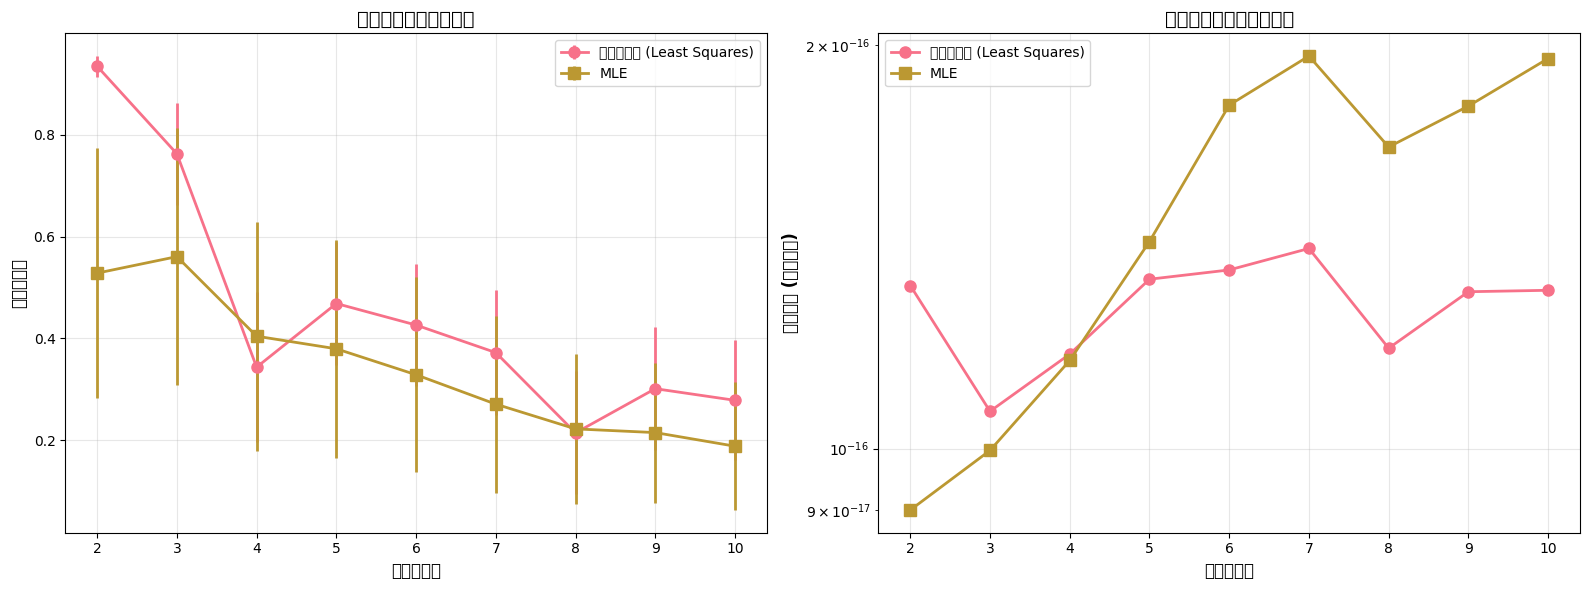

In [28]:
# 可视化可扩展性分析结果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 提取维度数值和保真度
dim_data = []
for dim_name, result_dict in all_results.items():
    # 提取维度数值
    dim_val = int(dim_name.split('×')[0].split('(')[0].strip())
    
    # 最小二乘法
    ls_result = result_dict.get('Least Squares', {})
    # MLE
    mle_result = result_dict.get('MLE', {})
    
    dim_data.append({
        'dim': dim_val,
        'ls_fid': ls_result.get('fidelity_mean', 0),
        'ls_fid_std': ls_result.get('fidelity_std', 0),
        'ls_cv': ls_result.get('cv_mean', 0),
        'mle_fid': mle_result.get('fidelity_mean', 0),
        'mle_fid_std': mle_result.get('fidelity_std', 0),
        'mle_cv': mle_result.get('cv_mean', 0)
    })

# 按维度排序
dim_data.sort(key=lambda x: x['dim'])
dimensions = [d['dim'] for d in dim_data]
ls_fidelities = [d['ls_fid'] for d in dim_data]
mle_fidelities = [d['mle_fid'] for d in dim_data]
ls_fid_stds = [d['ls_fid_std'] for d in dim_data]
mle_fid_stds = [d['mle_fid_std'] for d in dim_data]
ls_cvs = [d['ls_cv'] for d in dim_data]
mle_cvs = [d['mle_cv'] for d in dim_data]

# 绘制保真度随维度变化
ax1 = axes[0]
ax1.errorbar(dimensions, ls_fidelities, yerr=ls_fid_stds, 
             marker='o', label='最小二乘法 (Least Squares)', linewidth=2, markersize=8)
ax1.errorbar(dimensions, mle_fidelities, yerr=mle_fid_stds, 
             marker='s', label='MLE', linewidth=2, markersize=8)
ax1.set_xlabel('量子态维度', fontsize=12, fontweight='bold')
ax1.set_ylabel('保真度均值', fontsize=12, fontweight='bold')
ax1.set_title('保真度随维度变化趋势', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(dimensions)

# 绘制约束违反随维度变化
ax2 = axes[1]
ax2.semilogy(dimensions, ls_cvs, marker='o', label='最小二乘法 (Least Squares)', 
             linewidth=2, markersize=8)
ax2.semilogy(dimensions, mle_cvs, marker='s', label='MLE', 
             linewidth=2, markersize=8)
ax2.set_xlabel('量子态维度', fontsize=12, fontweight='bold')
ax2.set_ylabel('约束违反 (对数尺度)', fontsize=12, fontweight='bold')
ax2.set_title('约束违反随维度变化趋势', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(dimensions)

plt.tight_layout()

# 保存图片
image_path = os.path.join('images', 'scalability_analysis_extended.png')
if not os.path.exists('images'):
    os.makedirs('images')
plt.savefig(image_path, dpi=300, bbox_inches='tight')
print(f"可视化结果已保存到: {image_path}")

plt.show()
